In [20]:
#import user modules
#--- MATPLOTLIB
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.markers import MarkerStyle
from matplotlib.gridspec import GridSpec
import matplotlib.gridspec as grid
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd

import importlib as imp
import sys
my_path = "../../Python/"
if my_path not in sys.path:
    sys.path.append(my_path)
 
for place in sys.path: 
    print(place)

from fit_funcs import *
import costfun.costfun as cost
import utils.figures as fig_help
from utils.tools import *

imp.reload(fig_help)

import latex
import itertools
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['text.usetex'] = True
latex_engine = 'pdflatex'
latex_elements = {
    'extrapackages': r'\usepackage{physics}',
    'extrapackages': r'\usepackage{amsmath}'
}
#matplotlib.rcParams.update(matplotlib.rcParamsDefault)


%matplotlib inline
colors_ls = (list(mcolors.TABLEAU_COLORS)[:120])
colors_ls_cyc = itertools.cycle(colors_ls)
markers_ls = ['o','s','v', 'D', '<', 'X', '^', '*', '+']
markers = itertools.cycle(markers_ls)

#--- NUMERICAL LIBS
import numpy as np
import itertools
import math
import random
from cmath import nan
import h5py   


# SCIPY LIBS
import scipy.stats as statistics
from scipy.special import binom
from scipy.special import erfinv
from scipy.special import digamma
from scipy.special import polygamma
from scipy.special import lambertw
from scipy.optimize import curve_fit as fit
from scipy.signal import savgol_filter
from scipy import integrate
from scipy import fft
 
# OTHER
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
import copy
import os
from os import sep as kPSep
from os.path import exists

USE_SYMMETRIES = True
BOUNDARY_COND = 'PBC'

base_dir = "../results/" + ("symmetries/" if USE_SYMMETRIES else "disorder/") + BOUNDARY_COND + '/'


maks_data = '/Users/rafal.swietek/Library/CloudStorage/CloudMounter-RafałŚwiętek/Shared with me/Python/Colab/ProjectsData/2023_Integrable_XYZ_XXZ/DATA/RAW/SUSY/XYZ_M/'

print(base_dir)

from filesystem import *
from entropy import *

/Users/rafal.swietek/Projects/QHamSolver/XYZ/Jupyter_Python
/Users/rafal.swietek/opt/anaconda3/lib/python39.zip
/Users/rafal.swietek/opt/anaconda3/lib/python3.9
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/lib-dynload

/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/aeosa
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg
/Users/rafal.swietek/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions
/Users/rafal.swietek/.ipython
../../Python/
../results/symmetries/PBC/


In [2]:

parity_sectors = [-1, 1]
def get_sectors(L, hx=0, hz=0):
    translation_real_sectors = [0, L // 2] if BOUNDARY_COND == 'PBC' and L % 2 == 0 else [0]
    translation_imag_sectors = range(1, L // 2 + L % 2)
    
    spin_flip_Z_sectors = [-1, 1] if hx == 0 else [1]
    spin_flip_X_sectors = [-1, 1] if hz == 0 and (L % 2 == 0 or hx != 0) else [1]

    real_sectors = [[ks, ps, zx, zz] for ks in translation_real_sectors for ps in parity_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]
    imag_sectors = [[kx, 1, zx, zz] for kx in translation_imag_sectors for zx in spin_flip_X_sectors for zz in spin_flip_Z_sectors]

    return real_sectors, imag_sectors

# $$S_0=\frac{1}{L}\sum_{\ell,\ell'=1}^LS^+_\ell S^-_{\ell'}$$
# $$K_\ell=\frac{1}{2}\left(S^+_\ell S^-_{\ell+1}+S^-_{\ell}S^+_{\ell+1}\right)$$
# $$K=\frac{1}{\sqrt{L}}\frac{1}{2}\sum_{\ell=1}^LS^+_\ell S^-_{\ell+1}+S^-_{\ell} S^+_{\ell+1}$$

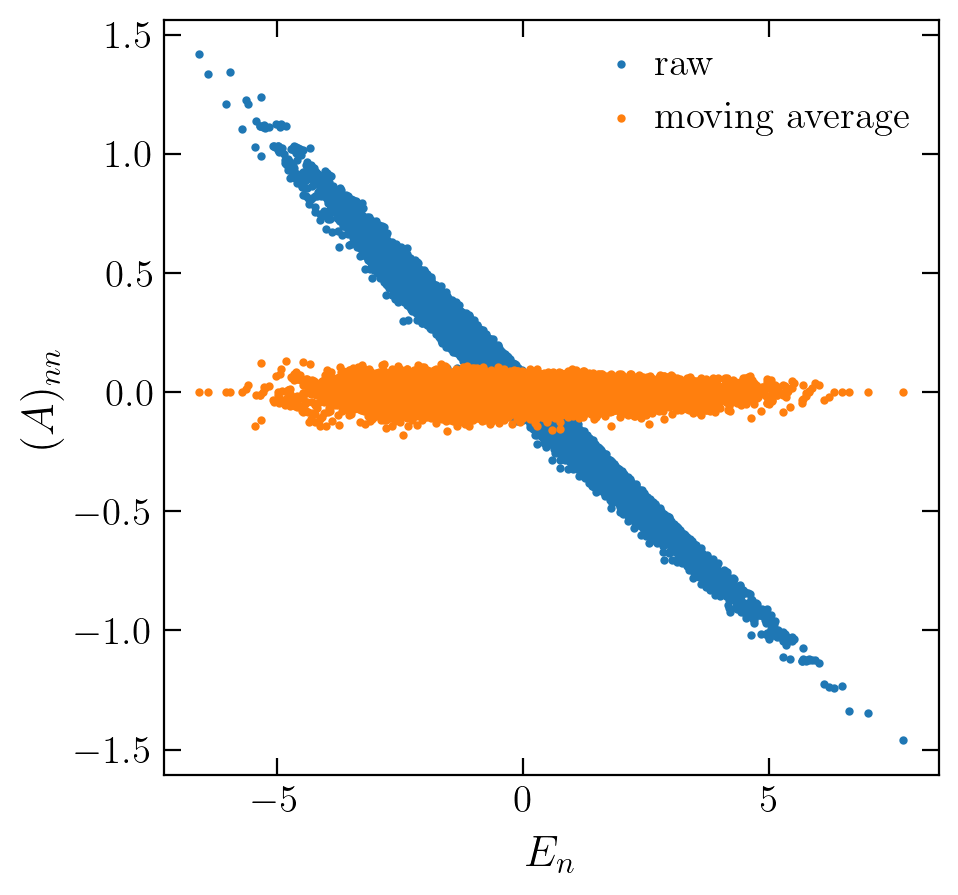

In [22]:
fig, axis = plt.subplots( nrows=1, ncols=1, figsize=(5,5), dpi = 200, sharex=True)

L=22
J1=1.0
d1=0.2
e1=0.2

ks=0
ps=1
zxs=1
zzs=1

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

REMOVE_STRUCTURE = 1

sizes = np.arange(14, 25, 2) if BOUNDARY_COND == 'PBC' else np.arange(12, 20, 2)


# ks = L//2
name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

if exists(name):
    with h5py.File(name, "r") as file:
        energies = np.array(file.get('energies')[0]) - L/8 * (3+e1**2)
        Sq0 = np.array(file.get('Sq0')[0]).view(data_type)
        Kin = np.array(file.get('Kin')[0]).view(data_type)
        Kin_loc = np.array(file.get('Kin_loc')[0]).view(data_type)
        # print(energies.shape, Sq0.shape)
        if ks != 0 and ks != L / 2:
            Sq0 = np.real(Sq0)
            Kin = np.real(Kin)
            Kin_loc = np.real(Kin_loc)


        data = Kin

        axis.scatter(energies, data, s=4, label='raw')
        data = get_fluctuations(data, bucket_size=10, type='mean')
        axis.scatter(energies, data, s=4, label="moving average")
        
else:
    print(name)



fig_help.set_plot_elements(axis, ylabel=r"$(A)_{nn}$", xlabel=r"$E_n$", font_size=14, set_legend=True)
axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.01,1.01))



fig.subplots_adjust(wspace = 0.3, hspace=0.05)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


../results/symmetries/PBC/DiagonalMatrixElements/_L=24,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,k=0,p=1,zx=1,zz=1,edge=0.hdf5


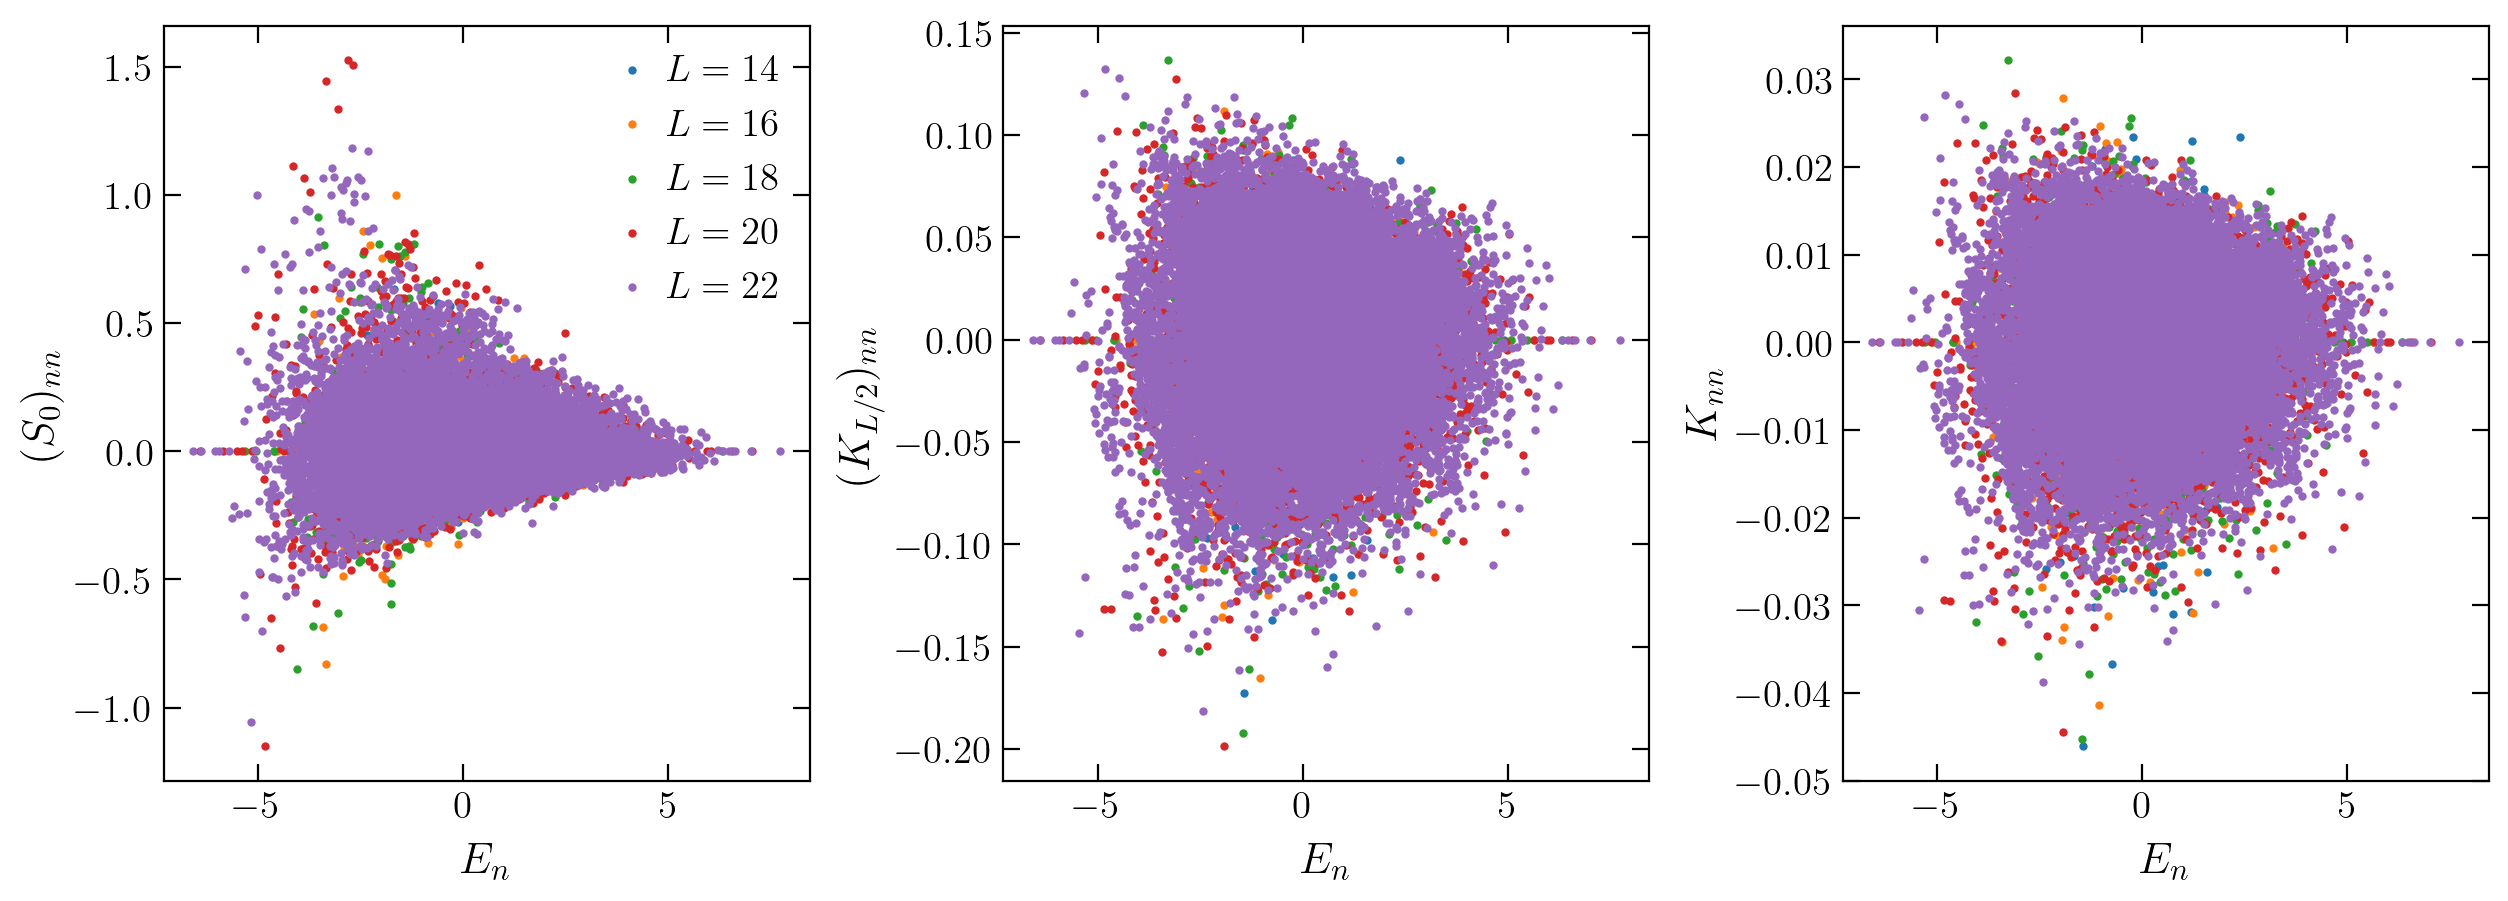

In [23]:
fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(15,5), dpi = 200, sharex=True)

L=18
J1=1.0
d1=0.2
e1=0.2

ks=0
ps=1
zxs=1
zzs=1

real_sec, imag_sec = get_sectors(L)
sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

REMOVE_STRUCTURE = 1

sizes = np.arange(14, 25, 2) if BOUNDARY_COND == 'PBC' else np.arange(12, 20, 2)


for L in sizes:
    # ks = L//2
    name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
    data_type = 'float' if ks == 0 or ks == L / 2 else 'complex'

    if exists(name):
        with h5py.File(name, "r") as file:
            energies = np.array(file.get('energies')[0]) - L/8 * (3+e1**2)
            Sq0 = np.array(file.get('Sq0')[0]).view(data_type)
            Kin = np.array(file.get('Kin')[0]).view(data_type)
            Kin_loc = np.array(file.get('Kin_loc')[0]).view(data_type)
            # print(energies.shape, Sq0.shape)
            if ks != 0 and ks != L / 2:
                Sq0 = np.real(Sq0)
                Kin = np.real(Kin)
                Kin_loc = np.real(Kin_loc)
            if REMOVE_STRUCTURE:
                Sq0     = get_fluctuations(Sq0, bucket_size=10, type='mean')
                Kin     = get_fluctuations(Kin, bucket_size=10, type='mean')
                Kin_loc = get_fluctuations(Kin_loc, bucket_size=10, type='mean')
            axis[0].scatter(energies, Sq0, s=4, label=r"$L=%d$"%L)
            axis[1].scatter(energies, Kin, s=4)
            axis[2].scatter(energies, Kin_loc, s=4)
    else:
        print(name)



fig_help.set_plot_elements(axis[0], ylabel=r"$(S_0)_{nn}$", xlabel=r"$E_n$", font_size=14, set_legend=True)
axis[0].legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.01,1.01))


fig_help.set_plot_elements(axis[1], ylabel=r"$(K_{L/2})_{nn}$", xlabel=r"$E_n$", font_size=14, set_legend=True)

fig_help.set_plot_elements(axis[2], ylabel=r"$K_{nn}$", xlabel=r"$E_n$", font_size=14, set_legend=True)


fig.subplots_adjust(wspace = 0.3, hspace=0.05)


In [1]:
fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(15,5), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2

sizes = np.arange(14, 23, 2) if BOUNDARY_COND == 'PBC' else np.arange(10, 19, 2)
Sq0 = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)

for ii_L, L in enumerate(sizes):
    real_sec, imag_sec = get_sectors(L)
    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

    Sq0_matelem = []
    Kin_matelem = []
    Kin_loc_matelem = []
    dim_tot = 0
    for [ks, ps, zxs, zzs] in real_sec:
        data_type = 'float' if ks == 0 or ks == L / 2 else [('real', '<f8'), ('imag', '<f8')]
    # for [ks, ps, zxs, zzs] in [[0,1,1,1]]:
        name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                dim = energies.size
                dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                if ks == 0 or ks == L / 2:
                    Sq0_tmp     = get_fluctuations(np.array(file.get('Sq0')[0]).view(data_type), bucket_size=10, type='mean')
                    Kin_tmp     = get_fluctuations(np.array(file.get('Kin')[0]).view(data_type), bucket_size=10, type='mean')
                    Kin_loc_tmp = get_fluctuations(np.array(file.get('Kin_loc')[0]).view(data_type), bucket_size=10, type='mean')
                else:
                    Sq0_tmp     = get_fluctuations(np.real(np.array(file.get('Sq0')[0]).view(data_type)), bucket_size=10, type='mean')
                    Kin_tmp     = get_fluctuations(np.real(np.array(file.get('Kin')[0]).view(data_type)), bucket_size=10, type='mean')
                    Kin_loc_tmp = get_fluctuations(np.real(np.array(file.get('Kin_loc')[0]).view(data_type)), bucket_size=10, type='mean')

                Sq0_matelem     = [*Sq0_matelem,        *Sq0_tmp]
                Kin_matelem     = [*Kin_matelem,        *Kin_tmp]
                Kin_loc_matelem = [*Kin_loc_matelem,    *Kin_loc_tmp]

                # Sq0[ii_L] += np.sum(np.abs(get_fluctuations(np.array(file.get('Sq0')[0], dtype=data_type)))**2)
                # Kin[ii_L] += np.sum(np.abs(get_fluctuations(np.array(file.get('Kin')[0], dtype=data_type)))**2)
                # Kin_loc[ii_L] += np.sum(np.abs(get_fluctuations(np.array(file.get('Kin_loc')[0], dtype=data_type) ))**2)

        else:
            print(name)

    Sq0[ii_L] = np.var(np.abs(Sq0_matelem))
    Kin[ii_L] = np.var(np.abs(Kin_matelem))
    Kin_loc[ii_L] = np.var(np.abs(Kin_loc_matelem))
    # Sq0[ii_L]       /= dim_tot
    # Kin[ii_L]       /= dim_tot
    # Kin_loc[ii_L]   /= dim_tot

def fit_to_dat(axis, x, y, col):
    pars, pconv = fit(power_law,
                    xdata = x[2:],
                    ydata = y[2:])
    print(L, pars)
    xval = np.linspace(min(x), max(x), 100)
    axis.plot(xval, power_law(xval, *pars), ls='--', color=col)

colors_ls_cyc = itertools.cycle(colors_ls)
sc = axis[0].scatter(sizes, Sq0, marker='o', color = next(colors_ls_cyc))
fit_to_dat(axis[0], sizes, Sq0, sc.get_facecolors()[0].tolist())

sc = axis[1].scatter((sizes), Kin_loc, marker='s', color = next(colors_ls_cyc))
fit_to_dat(axis[1], (sizes), Kin_loc, sc.get_facecolors()[0].tolist())

sc = axis[2].scatter((sizes), Kin, marker='^', color = next(colors_ls_cyc))
fit_to_dat(axis[2], (sizes), Kin, sc.get_facecolors()[0].tolist())

# axis.plot(sizes, 1e-4/sizes**2, ls='--', c='k')
# axis.plot(sizes, 5e-4*np.exp(-sizes*np.log(2)/2), ls=':', c='k')

# for ax in axis:
#     ax.plot(sizes, sizes, ls='--', c='k')
fig_help.set_plot_elements(axis[0], ylabel=r"$|(S_0)_{nn}|^{2}$", xlabel=r"$L$", font_size=14, set_legend=True, yscale='log', xscale='linear')
fig_help.set_plot_elements(axis[1], ylabel=r"$|(K_{L/2})_{nn}|^{2}$", xlabel=r"$L$", font_size=14, set_legend=True, yscale='log', xscale='linear')
fig_help.set_plot_elements(axis[2], ylabel=r"$|K_{nn}|^{2}$", xlabel=r"$L$", font_size=14, set_legend=True, yscale='log', xscale='linear')
# axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.01,1.01))



fig.subplots_adjust(wspace = 0.3, hspace=0.05)

NameError: name 'plt' is not defined

../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=-1,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=-1,zx=-1,zz=1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=-1,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=-1,zx=1,zz=1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=1,zx=-1,zz=-1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=1,zx=-1,zz=1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=1,zx=1,zz=-1,edge=0.hdf5
../results/symmetries/OBC/DiagonalMatrixElements/_L=10,J1=1,J2=0,d1=0.2,d2=0,e1=0.2,e2=0,hx=0,hz=0,p=1,zx=1,zz=1,

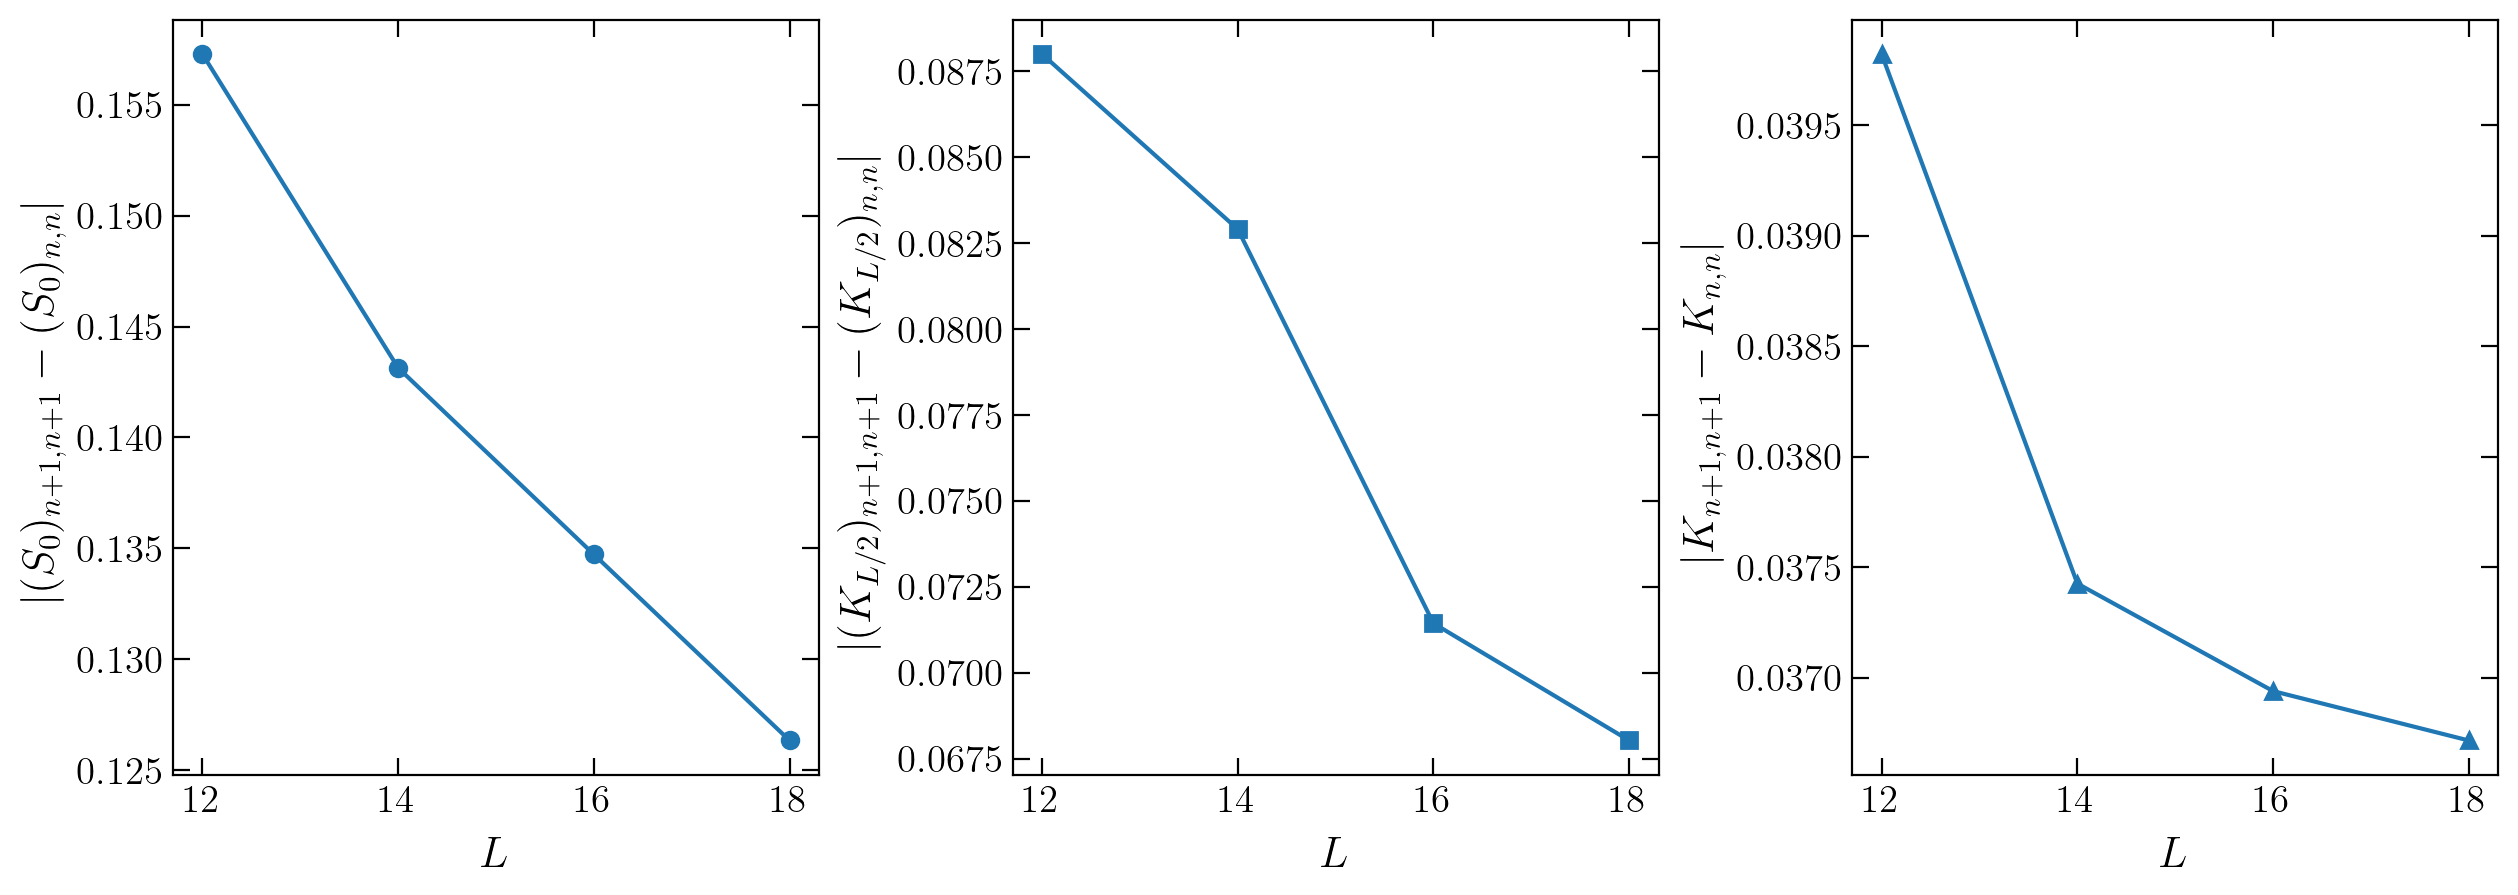

In [15]:
fig, axis = plt.subplots( nrows=1, ncols=3, figsize=(15,5), dpi = 200)

L=22
J1=1.0
d1=0.2
e1=0.2

sizes = np.arange(14, 25, 2) if BOUNDARY_COND == 'PBC' else np.arange(10, 20, 2)
Sq0 = np.zeros(sizes.shape)
Kin = np.zeros(sizes.shape)
Kin_loc = np.zeros(sizes.shape)

for ii_L, L in enumerate(sizes):
    real_sec, imag_sec = get_sectors(L)
    sects = real_sec + imag_sec if BOUNDARY_COND == 'PBC' else real_sec

    dim_tot = 0
    for [ks, ps, zxs, zzs] in real_sec:
        name = base_dir + 'DiagonalMatrixElements/' + info_sym(L=L, J1=J1, delta1=d1, eta1=e1, k=ks, p=ps, zx=zxs, zz=zzs, BOUNDARY_COND=BOUNDARY_COND) + ".hdf5"
        if exists(name):
            with h5py.File(name, "r") as file:
                energies = np.array(file.get('energies')[0])
                dim = energies.size

                if ks == 0 or ks == L / 2:
                    Sq0_matelem     = np.array(file.get('Sq0')[0]).view(data_type)
                    Kin_matelem     = np.array(file.get('Kin')[0]).view(data_type)
                    Kin_loc_matelem = np.array(file.get('Kin_loc')[0]).view(data_type)
                else:
                    Sq0_matelem     = np.real(np.array(file.get('Sq0')[0]).view(data_type))
                    Kin_matelem     = np.real(np.array(file.get('Kin')[0]).view(data_type))
                    Kin_loc_matelem = np.real(np.array(file.get('Kin_loc')[0]).view(data_type))


                dim_tot += dim if ks == 0 or ks == L / 2 else 2 * dim

                num = 0.5 * dim

                E_av = np.mean(energies)
                index_meanE = min(range(len(energies)), key=lambda i: abs(energies[i] - E_av))
                
                my_min = int(index_meanE - num / 2)
                if my_min < 0: my_min = 0;  

                my_max = int(index_meanE + num / 2) 
                if my_max >= dim: my_max = dim

                if num < dim and my_min > 0 and my_max < dim:
                    Sq0_matelem = np.diff(Sq0_matelem)[my_min : my_max]
                    Kin_matelem = np.diff(Kin_matelem)[my_min : my_max]
                    Kin_loc_matelem = np.diff(Kin_loc_matelem)[my_min : my_max]
                
                Sq0[ii_L] += np.mean(np.abs(Sq0_matelem)) * (dim  if ks == 0 or ks == L / 2 else 2*dim)
                Kin[ii_L] += np.mean(np.abs(Kin_matelem)) * (dim  if ks == 0 or ks == L / 2 else 2*dim)
                Kin_loc[ii_L] += np.mean(np.abs(Kin_loc_matelem)) * (dim  if ks == 0 or ks == L / 2 else 2*dim)

        else:
            print(name)
    if dim_tot != 2**L:
        print("Missing sector:", dim_tot, 2**L)
    Sq0[ii_L] /= dim_tot
    Kin[ii_L] /= dim_tot
    Kin_loc[ii_L] /= dim_tot

axis[0].plot(sizes, Sq0, marker='o')
axis[1].plot(sizes, Kin_loc, marker='s')
axis[2].plot(sizes, Kin, marker='^')

# axis.plot(sizes, 1e-4/sizes**2, ls='--', c='k')
# axis.plot(sizes, 5e-4*np.exp(-sizes*np.log(2)/2), ls=':', c='k')

fig_help.set_plot_elements(axis[0], ylabel=r"$|(S_0)_{n+1,n+1}-(S_0)_{n,n}|$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[1], ylabel=r"$|(K_{L/2})_{n+1,n+1}-(K_{L/2})_{n,n}|$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
fig_help.set_plot_elements(axis[2], ylabel=r"$|K_{n+1,n+1}-K_{n,n}|$", xlabel=r"$L$", font_size=14, set_legend=False, yscale='linear', xscale='linear')
# axis.legend(frameon=0, fontsize=14, loc='upper right', handletextpad=0.25, handlelength = 1.25, bbox_to_anchor=(1.01,1.01))



fig.subplots_adjust(wspace = 0.3, hspace=0.05)